# **Modèle personnel**

<div class="alert alert-info">
Nous allons créer un modèle personnel, dont l'architecture sera basée sur VGG16. Afin de limiter les temps de calculs, bien qu'accélérés grâce à une carte graphique, nous ne baserons nos expérimentations que sur 10 classes.
</div>

### **Importation des bibliothèques**

In [1]:
import os  # Manipulations de fichiers
import shutil  # Pour supprimer un dossier non vide
import random  # Utilisé lors de la séparation train/test
from math import ceil  # Utilisé lors de la séparation train/test
import numpy as np  # Manipulation d'arrays et utilisation de np.argmax
import time  # Mesures des durées d'éxécution

# Désactivation des messages de debugging de tensorflow.
# Doit être exécuté avant les imports de tensorflow.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
# Permettra de filtrer les warning de tensorflow lors de l'enregistrement
# des poids des modèles
warnings.filterwarnings("ignore")

# Préparation des données, création du modèle, data augmentation
from tensorflow import device
from tensorflow.config import list_physical_devices
from tensorflow.keras.utils import image_dataset_from_directory, set_random_seed
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout, Conv2D, MaxPool2D, MaxPooling2D
from tensorflow.keras.layers import Rescaling, RandomBrightness, RandomContrast, RandomFlip, RandomRotation, RandomTranslation, RandomZoom 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Calcul des métriques
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, recall_score

# Visualisations
import matplotlib.pyplot as plt

### **Mesure de la durée d'exécution du notebook**

In [2]:
t_notebook = time.time()

### **Création d'une seed pour stabiliser les résultats.**

Malgré ceci, les calculs réalisés à l'aide d'une carte graphique peuvent parfois amener un peu de variabilité.<br>
Stabiliser les résultats permet de plus facilement comparer les résultats, notamment lors du tuning des hyperparamètres.

In [3]:
seed = 42
# Paramétrer la seed de numpy, tensorflow et python : 
set_random_seed(seed)
random.seed(seed)

## **A). Création d'un répertoire avec séparation train/test**

In [4]:
# Proportion des échantillons à utiliser pour le train
split_ratio = 0.8

# Répertoire source : images avec prétraitements de base (sans whitening)
input_folder = "data/dogs_10_classes_proc"

# Répertoire cible
output_folder = input_folder + "_splited"

debut = time.time()  # Heure de début du traitement

# Nombre de sous dossiers, autrement dit : nombre de classe
# je mets cette valeur de côté, on en aura besoin pour la structure du modèle
nb_classes = len(os.listdir(input_folder))

# Si le dossier existe déjà
# suppression du dossier et de son contenu avec shutil
if os.path.exists(output_folder):
    shutil.rmtree(output_folder)

# Créer les dossiers train et test dans le dossier de sortie
train_folder = os.path.join(output_folder, 'train')
test_folder = os.path.join(output_folder, 'test')
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# Parcourir les sous-dossiers du dossier d'origine
for label_folder in os.listdir(input_folder):
    label_path = os.path.join(input_folder, label_folder)
    if os.path.isdir(label_path):
        # Liste des fichiers dans le sous-dossier
        files = os.listdir(label_path)
        # Calculer le nombre de fichiers à utiliser pour l'entraînement
        train_count = ceil(len(files) * split_ratio)
        # Mélanger la liste des fichiers de manière aléatoire
        random.shuffle(files)
        
        # Diviser les fichiers entre train et test
        train_files = files[:train_count]
        test_files = files[train_count:]

        # Créer les sous-dossiers correspondants dans les dossiers train et test
        train_label_folder = os.path.join(train_folder, label_folder)
        test_label_folder = os.path.join(test_folder, label_folder)
        os.makedirs(train_label_folder, exist_ok=True)
        os.makedirs(test_label_folder, exist_ok=True)

        # Copier les fichiers dans les sous-dossiers correspondants
        for file in train_files:
            shutil.copy(os.path.join(label_path, file), os.path.join(train_label_folder, file))
        
        for file in test_files:
            shutil.copy(os.path.join(label_path, file), os.path.join(test_label_folder, file))

path = output_folder+"/train"
path_test = output_folder+"/test"

print(f"Durée de création : {(time.time() - debut):.2f} s")

Durée de création : 42.01 s


## **B). Création des datasets tensorflow**

In [5]:
# Taille des batchs des datasets
batch_size = 32

# Si les images en entrée n'ont pas la bonne taille,
# elles seront redimensionnées à cette taille
images_size = (224, 224)

def dataset_fct(path, validation_split=0, data_type=None, img_size=(224, 224)) :
    dataset = image_dataset_from_directory(path,
                                           labels='inferred',
                                           label_mode='categorical',
                                           class_names=None,
                                           batch_size=batch_size,
                                           image_size=img_size,
                                           crop_to_aspect_ratio=True,  # Si l'image est redimensionnée et qu'elle n'avait pas
                                                                       # le même aspect ratio, alors elle sera recadrée pour
                                                                       # correspondre. Si False, l'image ne sera pas recadrée,
                                                                       # mais elle pourra alors être déformée.
                                           shuffle=True,
                                           seed=seed,
                                           validation_split=validation_split,
                                           subset=data_type
              )
    return dataset

In [6]:
debut = time.time()  # Heure de début du traitement

dataset_train = dataset_fct(path,
                            validation_split=0.25,
                            data_type='training',
                            img_size=images_size
                )

dataset_val = dataset_fct(path,
                          validation_split=0.25,
                          data_type='validation',
                          img_size=images_size
                )

dataset_test = dataset_fct(path_test,
                           validation_split=0,
                           data_type=None,
                           img_size=images_size
               )

print(f"\nDurée de création : {(time.time() - debut):.2f} s")

Found 1513 files belonging to 10 classes.
Using 1135 files for training.
Found 1513 files belonging to 10 classes.
Using 378 files for validation.
Found 373 files belonging to 10 classes.

Durée de création : 6.28 s


Nous savons que les images train/test sont bien séparées, puisque nous les avons mises dans des dossiers différents. Mais est-ce que notre fonction dataset_fct() a bien utilisé des images différentes pour train/val ? Vérifions-le.

In [7]:
# .file_paths permet de retourner le chemin des images utilisées pour construire le dataset tensorflow.
# "set(A) & set(B)" retourne les éléments communs entre les sets A et B
print(f"Élements communs entre 'dataset_train' et 'dataset_val' : {len(set(dataset_train.file_paths) & set(dataset_val.file_paths))}")

Élements communs entre 'dataset_train' et 'dataset_val' : 0


In [8]:
print(f"Images dans 'dataset_train' : {len(dataset_train.file_paths)}")
print(f"Images dans 'dataset_val' : {len(dataset_val.file_paths)}")
print(f"Images dans 'dataset_test' : {len(dataset_test.file_paths)}")

Images dans 'dataset_train' : 1135
Images dans 'dataset_val' : 378
Images dans 'dataset_test' : 373


### **Exemple d'image du dataset de train**

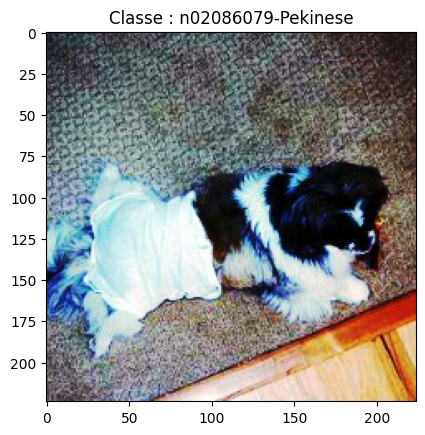

In [9]:
# Récupération du nom des classes (nom des sous dossiers)
# On utilisera aussi cette varibale pour décoder nos prédictions
# sur de nouveaux échantillons
class_names = os.listdir(input_folder)

# Sortir un batch du dataset
for images, labels_encoded in dataset_train.take(1):
    # Convertir les labels encodés en indices de classe
    class_indices = np.argmax(labels_encoded, axis=1)  # np.argmax sert à trouver l'indice de la valeur la plus élevée
                                                       # labels_encoded qui est onehot encodé.
                                                       # ex : argmax([[0, 1, 0]], axis=1).numpy()[0] retourne 1
                                                       # (les indices commencent à 0)
    
    # Récupérer les noms de classe correspondants aux indices
    class_labels = [class_names[i] for i in class_indices]

# Afficher la première image du batch du dataset de train
plt.imshow(images[0].numpy().astype("uint8"))
plt.title(f"Classe : {class_labels[0]}")
plt.show()


### **Classes**

In [10]:
print(f"Les {len(class_names)} classes présentes dans ce dataset :\n")
for i in range(len(class_names)):
    print(f"- {class_names[i]}")

Les 10 classes présentes dans ce dataset :

- n02085620-Chihuahua
- n02085782-Japanese_spaniel
- n02085936-Maltese_dog
- n02086079-Pekinese
- n02086240-Shih-Tzu
- n02086646-Blenheim_spaniel
- n02086910-papillon
- n02087046-toy_terrier
- n02087394-Rhodesian_ridgeback
- n02088094-Afghan_hound


## **C). Modèle de base**

### **1). Création et entraînement du modèle**

#### **Fonction de création**

Nous allons nous baser sur l'architecture de VGG16, que l'on peut retrouver [ici](https://github.com/keras-team/keras-applications/blob/master/keras_applications/vgg16.py).

In [11]:
def create_model_base() :
    
    # Taille des images en entrée
    # On reprend bien la taille qu'on avait spécifiée
    # lors de la création de nos datasets
    input_shape = (224, 224, 3)

    # Structure du modèle
    model = Sequential([

    # BLOC 1
    Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape, name='block1_conv1'),
    Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', name='block1_conv2'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='block1_pool'),
    
    # BLOC 2
    Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu', name='block2_conv1'),
    Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu', name='block2_conv2'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='block2_pool'),

    # BLOC 3    
    Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu', name='block3_conv1'),
    Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu', name='block3_conv2'),
    Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu', name='block3_conv3'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='block3_pool'),

    # BLOC 4    
    Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu', name='block4_conv1'),
    Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu', name='block4_conv2'),
    Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu', name='block4_conv3'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='block4_pool'),

    # BLOC 5
    Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu', name='block5_conv1'),
    Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu', name='block5_conv2'),
    Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu', name='block5_conv3'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='block5_pool'),

    # Bloc de classification
    Flatten(name='flatten'),
    Dense(4096, activation='relu', name='fc1'),
    Dense(4096, activation='relu', name='fc2'),
    Dense(nb_classes, activation='softmax', name='predictions')  # nb_classes : nombre de classes, défini lors
                                                                 # de la création des répertoires train/test

    ], name='Base')

    # Compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    # Affichage de la structure du modèle
    print(model.summary())
    
    return model

#### **Création**

In [12]:
# Création du modèle
with device('/gpu:0'):    
    model_base = create_model_base()

Model: "Base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       295168 

#### **Création du callback**

In [13]:
model_base_save_path = "./model_perso_base_best_weights.h5"

checkpoint = ModelCheckpoint(model_base_save_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min'
             )

es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=5  # Nombre d'epoch sans amélioration à attendre
                               # avant d'interrompre l'entraînement
     )

callbacks_list_base = [checkpoint, es]

#### **Entraînement du modèle**

In [14]:
print("GPUs disponibles :", len(list_physical_devices('GPU')), "\n")

debut = time.time()  # Heure de début du traitement

with device('/gpu:0'): 
    history_base = model_base.fit(dataset_train,
                                  validation_data=dataset_val,
                                  batch_size=batch_size,  # On reprend le même batchsize que lors de la création des datasets
                                  epochs=50,
                                  callbacks=callbacks_list_base,
                                  verbose=1
                   )

model_base_fit_time = (time.time() - debut)

print(f"\nDurée d'entraînement : {model_base_fit_time:.2f} s")

GPUs disponibles : 1 

Epoch 1/50


36/36 [==============================] - ETA: 0s - loss: 332.0134 - accuracy: 0.1269
Epoch 1: val_loss improved from inf to 2.29904, saving model to ./model_perso_base_best_weights.h5
36/36 [==============================] - 19s 279ms/step - loss: 332.0134 - accuracy: 0.1269 - val_loss: 2.2990 - val_accuracy: 0.1429
Epoch 2/50
36/36 [==============================] - ETA: 0s - loss: 2.3001 - accuracy: 0.1172
Epoch 2: val_loss improved from 2.29904 to 2.29473, saving model to ./model_perso_base_best_weights.h5
36/36 [==============================] - 8s 214ms/step - loss: 2.3001 - accuracy: 0.1172 - val_loss: 2.2947 - val_accuracy: 0.1111
Epoch 3/50
36/36 [==============================] - ETA: 0s - loss: 2.2956 - accuracy: 0.1339
Epoch 3: val_loss did not improve from 2.29473
36/36 [==============================] - 6s 144ms/step - loss: 2.2956 - accuracy: 0.1339 - val_loss: 2.2947 - val_accuracy: 0.1111
Epoch 4/50
36/36 [==============================] - ETA: 0s - loss: 2.2908 - accur

### **2). Évaluation du modèle**

#### **Fonctions d'évaluation**

In [15]:
def show_train_metrics(history):

    """
    Cette fonction affiche l'historique des métriques (perte et accuracy)
    lors de l'entraînement d'un modèle Keras.
    
    Elle prend en entrée l'historique retourné par le modèle lors de l'entraînement.
    """
    
    # Accéder au dictionnaire contenant les métriques
    metrics_dict = history.history

    # Graphique des résultats d'entraînement :
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Tracer la courbe de perte d'entraînement et de validation
    ax1.plot(metrics_dict['loss'], label=f'Training Loss (dernier : {metrics_dict["loss"][-1]:.4f})')
    ax1.plot(metrics_dict['val_loss'], label=f'Validation Loss (dernier : {metrics_dict["val_loss"][-1]:.4f})')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.legend()
    ax1.set_title('\nTraining and Validation Loss\n', fontsize=14)
    ax1.grid(True, linestyle=':', alpha=0.8)

    # Tracer la courbe d'accuracy d'entraînement et de validation
    ax2.plot(metrics_dict['accuracy'], label=f'Training Accuracy (dernier : {metrics_dict["accuracy"][-1]*100:.2f}%)')
    ax2.plot(metrics_dict['val_accuracy'], label=f'Validation Accuracy (dernier : {metrics_dict["val_accuracy"][-1]*100:.2f}%)')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.legend()
    ax2.set_title('\nTraining and Validation Accuracy\n', fontsize=14)
    ax2.grid(True, linestyle=':', alpha=0.8)

    plt.show()

In [16]:
def show_metrics_and_matrix(model=None, dataset=None):
    
    """
    Cette fonction sert à afficher la matrice de confusion
    des prédictions réalisées par le modèle.
    Prend en entrée : 
    - Le modèle entraîné
    - Le dataset (de type tf.Dataset)
    """

    if not model or not dataset:
        print("Il faut préciser le modèle et le dataset")
        return

    # On crée les arrays qui vont contenir
    # les labels prédits et les labels réels
    pred_labels = np.array([])
    true_labels =  np.array([])

    # On va itérer par batch sur le dataset
    # pour récupérer à chaque fois les labels prédits et réels
    for x, y in dataset:
       # argmax(x, axis=-1) : retourne la position de la valeur max
       pred_labels = np.concatenate([pred_labels, np.argmax(model.predict(x, verbose=0), axis=-1)]) 
       true_labels = np.concatenate([true_labels, np.argmax(y.numpy(), axis=-1)])

    # Affichage des métriques
    print("=== Scores pour les prédictions ===")
    accuracy = accuracy_score(true_labels, pred_labels)
    print(f"Accuracy score : {accuracy:.3f}")
    # average='weighted' : prendre en compte l'importance de chaque classe
    # zero_division=0 : si une classe n'est pas du tout prédite, la précision sera fixée à 0
    precision = precision_score(true_labels, pred_labels, average='weighted', zero_division=0)
    print(f"Precision score : {precision:.3f}")
    recall = recall_score(true_labels, pred_labels, average='weighted')
    print(f"Recall score : {recall:.3f}")
    f1 = f1_score(true_labels, pred_labels, average='weighted')
    print(f"F1 score : {f1:.3f}")
    print("===================================")

    # Création de la matrice de confusion
    cm = confusion_matrix(true_labels, pred_labels, normalize='pred')
    # Affichage de la matrice de confusion
    cmp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots(figsize=(10,10))
    plt.title("\nMatrice de confusion\n", fontsize=20)
    plt.xlabel("", fontsize=16)
    plt.ylabel("", fontsize=16)
    cmp.plot(ax=ax, cmap=plt.cm.PuBuGn)

    return accuracy, precision, recall, f1

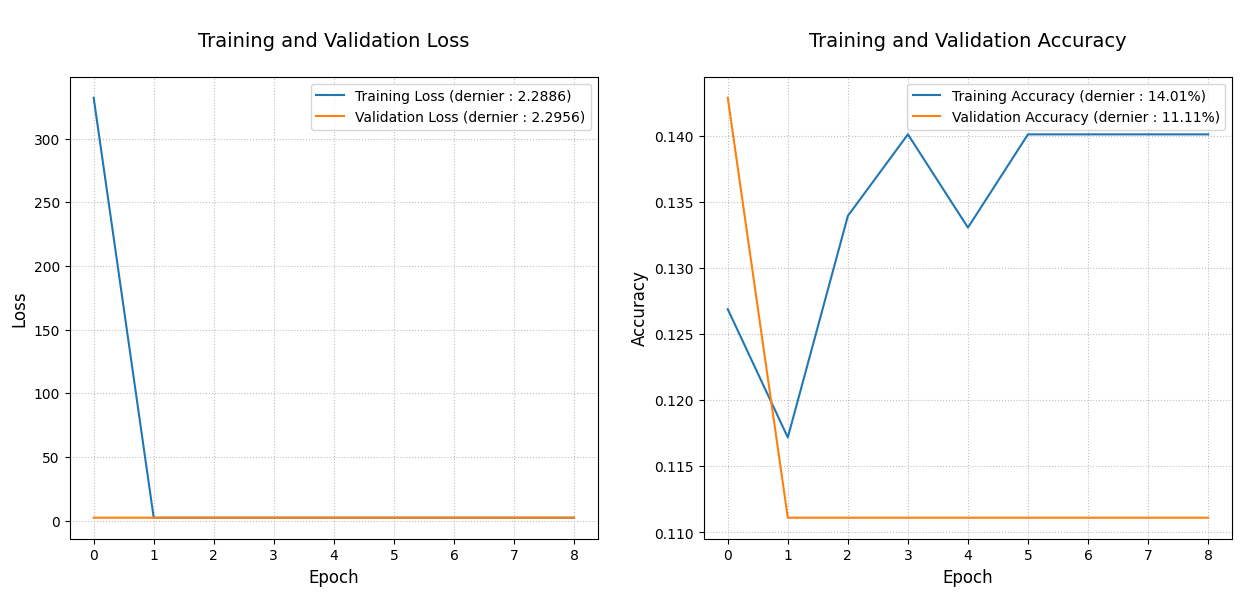

In [17]:
show_train_metrics(history=history_base)

In [18]:
# Score du dernier epoch
print("=== Dernier epoch ===")
loss, accuracy = model_base.evaluate(dataset_train, verbose=False)
print(f"Training Accuracy   : {accuracy:.3f}")
loss, accuracy = model_base.evaluate(dataset_val, verbose=False)
print(f"Validation Accuracy : {accuracy:.3f}")

# Score de l'epoch optimal
print("=== Epoch optimal ===")
# Chargement des poids optimaux
model_base.load_weights(model_base_save_path)
loss, accuracy = model_base.evaluate(dataset_val, verbose=False)
print(f"Validation Accuracy : {accuracy:.3f}")
loss, accuracy = model_base.evaluate(dataset_test, verbose=False)
print(f"Test Accuracy       : {accuracy:.3f}")

=== Dernier epoch ===
Training Accuracy   : 0.140
Validation Accuracy : 0.111
=== Epoch optimal ===
Validation Accuracy : 0.111
Test Accuracy       : 0.134


=== Scores pour les prédictions ===
Accuracy score : 0.134
Precision score : 0.018
Recall score : 0.134
F1 score : 0.032


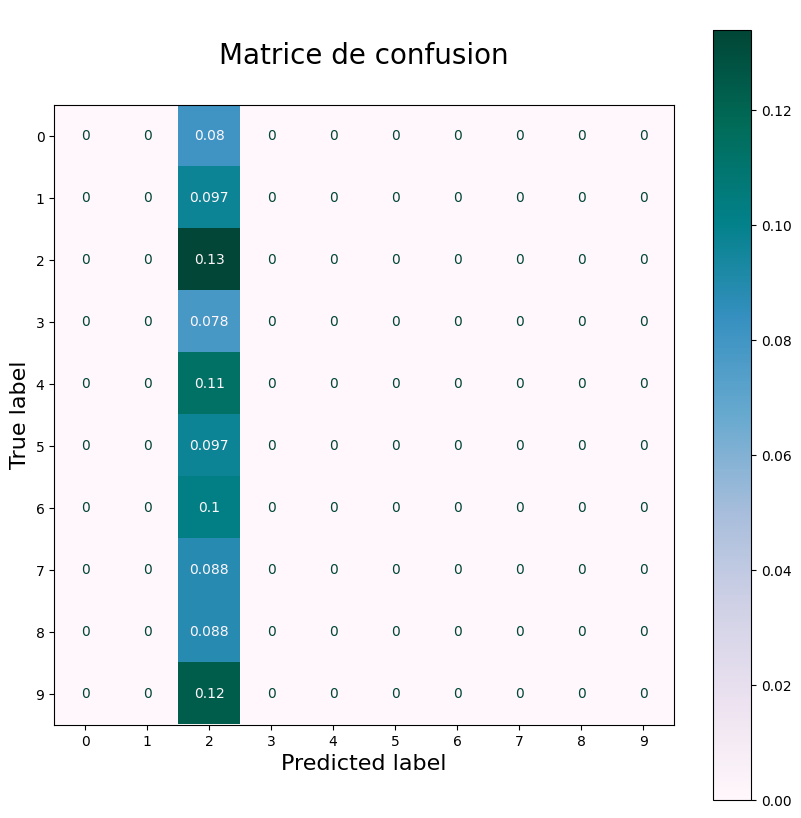

In [19]:
accuracy_base, precision_base, recall_base, f1_base = show_metrics_and_matrix(model=model_base, dataset=dataset_test)

<div class="alert alert-info">
Le modèle n'est pas du tout performant, il ne sait prédire qu'une seule classe. Une prédiction aléatoire avec 10 classes donnerait une accuracy de 10%, nous sommes ici à 13%.
</div>

## **D). Modèle optimisé : ajout d'une étape de data augmentation**

### **1). Création et entraînement du modèle**

#### **Fonction de création**

Nous allons encore nous baser sur l'architecture de VGG16, que l'on peut retrouver [ici](https://github.com/keras-team/keras-applications/blob/master/keras_applications/vgg16.py). Nous allons ajouter une étape de data augmentation au début.

In [20]:
def create_model_opti() :
    
    # Taille des images en entrée
    # On reprend bien la taille qu'on avait spécifiée
    # lors de la création de nos datasets
    input_shape = (224, 224, 3)

    # Définition de l'étape de data augmentation
    data_augmentation = Sequential([RandomBrightness(factor=0.1,
                                                     seed=seed,
                                                     input_shape=input_shape,  # Ça sera le premier layer, il faut donc indiquer la taille de l'input
                                                     name="RandomBrightness"
                                    ),
                                    RandomContrast(factor=0.1,
                                                   seed=seed,
                                                   name="RandomContrast"
                                    ),
                                    RandomFlip(mode="horizontal",
                                               seed=seed,
                                               name="RandomFlip"
                                    ),
                                    RandomRotation(0.1,
                                                   fill_mode='reflect',
                                                   interpolation='bilinear',
                                                   seed=seed,
                                                   name="RandomRotation"
                                    ),
                                    RandomTranslation(height_factor=0.1,
                                                      width_factor=0.1, 
                                                      fill_mode='reflect',
                                                      interpolation='bilinear',
                                                      seed=seed,
                                                      name="RandomTranslation"
                                    ),
                                    RandomZoom(height_factor=0.1,
                                               width_factor=None,  # Ainsi, l'aspect ratio sera préservé
                                               fill_mode='reflect',
                                               interpolation='bilinear',
                                               seed=seed,
                                               name="RandomZoom"
                                    )], name='Augmentation')

    # Structure du modèle
    model = Sequential([

    # Étape de data augmentation
    data_augmentation,    
    
    # BLOC 1
    Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', name='block1_conv1'),
    Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', name='block1_conv2'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='block1_pool'),
    
    # BLOC 2
    Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu', name='block2_conv1'),
    Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu', name='block2_conv2'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='block2_pool'),

    # BLOC 3    
    Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu', name='block3_conv1'),
    Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu', name='block3_conv2'),
    Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu', name='block3_conv3'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='block3_pool'),

    # BLOC 4    
    Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu', name='block4_conv1'),
    Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu', name='block4_conv2'),
    Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu', name='block4_conv3'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='block4_pool'),

    # BLOC 5
    Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu', name='block5_conv1'),
    Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu', name='block5_conv2'),
    Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu', name='block5_conv3'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='block5_pool'),

    # Bloc de classification
    Flatten(name='flatten'),
    Dense(4096, activation='relu', name='fc1'),
    Dense(4096, activation='relu', name='fc2'),
    Dense(nb_classes, activation='softmax', name='predictions')  # nb_classes : nombre de classes, défini lors
                                                                 # de la création des répertoires train/test

    ], name='Opti')

    # Compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    # Affichage de la structure du modèle
    print(model.summary())
    
    return model

#### **Création**

In [21]:
# Création du modèle
with device('/gpu:0'):    
    model_opti = create_model_opti()

Model: "Opti"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Augmentation (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0      

#### **Création du callback**

In [22]:
model_opti_save_path = "./model_perso_opti_best_weights.h5"

checkpoint = ModelCheckpoint(model_opti_save_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min'
             )

es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=5  # Nombre d'epoch sans amélioration à attendre
                               # avant d'interrompre l'entraînement
     )

callbacks_list_opti = [checkpoint, es]

#### **Entraînement du modèle**

In [23]:
print("GPUs disponibles :", len(list_physical_devices('GPU')), "\n")

debut = time.time()  # Heure de début du traitement

with device('/gpu:0'): 
    history_opti = model_opti.fit(dataset_train,
                                  validation_data=dataset_val,
                                  batch_size=batch_size, # On reste avec une taille de batch_size
                                  epochs=50,
                                  callbacks=callbacks_list_opti,
                                  verbose=1
                   )

model_opti_fit_time = (time.time() - debut)

print(f"\nDurée d'entraînement : {model_opti_fit_time:.2f} s")

GPUs disponibles : 1 

Epoch 1/50


36/36 [==============================] - ETA: 0s - loss: 266.4877 - accuracy: 0.1392
Epoch 1: val_loss improved from inf to 2.29674, saving model to ./model_perso_opti_best_weights.h5
36/36 [==============================] - 12s 219ms/step - loss: 266.4877 - accuracy: 0.1392 - val_loss: 2.2967 - val_accuracy: 0.0979
Epoch 2/50
36/36 [==============================] - ETA: 0s - loss: 2.2982 - accuracy: 0.1181
Epoch 2: val_loss improved from 2.29674 to 2.29650, saving model to ./model_perso_opti_best_weights.h5
36/36 [==============================] - 8s 208ms/step - loss: 2.2982 - accuracy: 0.1181 - val_loss: 2.2965 - val_accuracy: 0.1111
Epoch 3/50
36/36 [==============================] - ETA: 0s - loss: 2.2917 - accuracy: 0.1392
Epoch 3: val_loss improved from 2.29650 to 2.29583, saving model to ./model_perso_opti_best_weights.h5
36/36 [==============================] - 8s 224ms/step - loss: 2.2917 - accuracy: 0.1392 - val_loss: 2.2958 - val_accuracy: 0.1111
Epoch 4/50
36/36 [========

### **2). Évaluation du modèle**

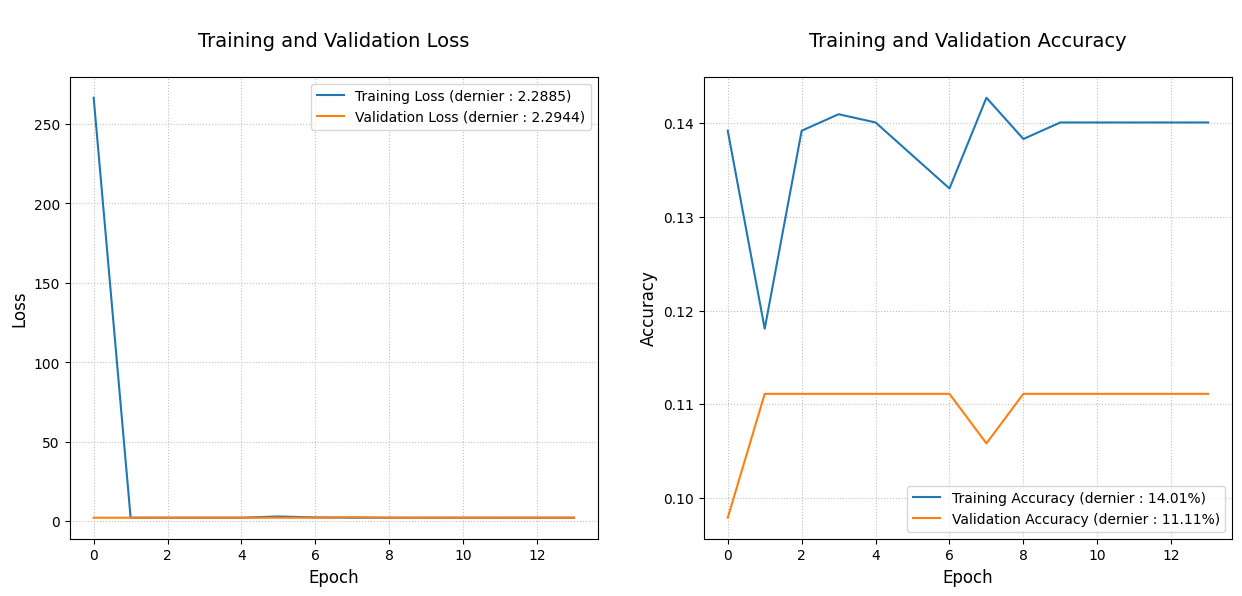

In [24]:
show_train_metrics(history=history_opti)

In [25]:
# Score du dernier epoch
print("=== Dernier epoch ===")
loss, accuracy = model_opti.evaluate(dataset_train, verbose=False)
print(f"Training Accuracy   : {accuracy:.3f}")
loss, accuracy = model_opti.evaluate(dataset_val, verbose=False)
print(f"Validation Accuracy : {accuracy:.3f}")

# Score de l'epoch optimal
print("=== Epoch optimal ===")
# Chargement des poids optimaux
model_opti.load_weights(model_opti_save_path)
loss, accuracy = model_opti.evaluate(dataset_val, verbose=False)
print(f"Validation Accuracy : {accuracy:.3f}")
loss, accuracy = model_opti.evaluate(dataset_test, verbose=False)
print(f"Test Accuracy       : {accuracy:.3f}")

=== Dernier epoch ===
Training Accuracy   : 0.140
Validation Accuracy : 0.111
=== Epoch optimal ===
Validation Accuracy : 0.111
Test Accuracy       : 0.134


=== Scores pour les prédictions ===
Accuracy score : 0.134
Precision score : 0.018
Recall score : 0.134
F1 score : 0.032


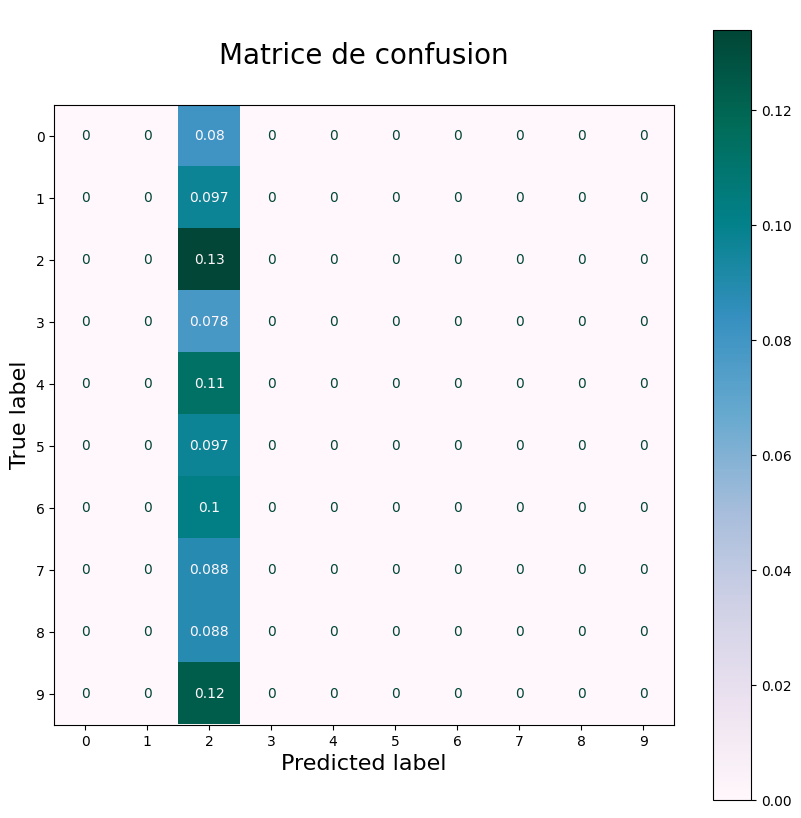

In [26]:
accuracy_opti, precision_opti, recall_opti, f1_opti = show_metrics_and_matrix(model=model_opti, dataset=dataset_test)

<div class="alert alert-info">
L'étape de data augmentation à augmenté la durée d'entraînement du modèle, sans modifier sa performance, toujours très mauvaise.
</div>

## **E). Modèle optimisé : ajustement des hyperparamètres**

### **1). Création et entraînement du modèle**

#### **Fonction de création**

Nous allons encore nous baser sur l'architecture de VGG16, que l'on peut retrouver [ici](https://github.com/keras-team/keras-applications/blob/master/keras_applications/vgg16.py).<br>

Les hyperparamètres suivants sont modifiés :

- Passage du batch_size à 100 dans *model.fit*
- Ajout de couches de Dropout : passage à 0 de certains neurones de manière aléatoire. Permet de réduire l'overfitting et au modèle de mieux généraliser.
- kernel_size=(3, 3) → kernel_size=(6, 6) pour *block1_conv1* et *block5_conv3*
- activation='relu' → activation='LeakyReLU' pour *block1_conv1* et *block1_conv2*
- optimizer='adam' → optimizer='Adagrad' dans *model.compile*

<div class="alert alert-info">
<li>Il n'a pas été nécessaire d'augmenter le nombre d'epochs, car le modèle arrête toujours l'entraînement avant les 50 epochs paramétrées (<i>early stopping</i>).<br>
<li>La fonction de perte <i>categorical_crossentropy</i> était déjà celle qui apportait les meilleurs résultats.<br>
<li><i>softmax</i> est la fonction d'activation la plus adaptée pour un layer de sortie dans une classification multiclasses.<br>
<li>L'ajout d'une étape de data augmentation ici n'améliorait pas significativement des résultats.
</div>

In [27]:
def create_model_opti_tuning() :
    
    # Taille des images en entrée
    # On reprend bien la taille qu'on avait spécifiée
    # lors de la création de nos datasets
    input_shape = (224, 224, 3)

    # Structure du modèle
    model = Sequential([

    # BLOC 1
    Conv2D(64, kernel_size=(6, 6), padding='same', activation='LeakyReLU', input_shape=input_shape, name='block1_conv1'),  # Ça sera le premier layer, il faut donc indiquer la taille de l'input 
    Conv2D(64, kernel_size=(3, 3), padding='same', activation='LeakyReLU', name='block1_conv2'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='block1_pool'),

    # Ajout d'un dropout
    Dropout(0.25, name='dropout_1_25'),
    
    # BLOC 2
    Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu', name='block2_conv1'),
    Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu', name='block2_conv2'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='block2_pool'),

    # Ajout d'un dropout
    Dropout(0.25, name='dropout_2_25'),

    # BLOC 3    
    Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu', name='block3_conv1'),
    Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu', name='block3_conv2'),
    Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu', name='block3_conv3'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='block3_pool'),

    # Ajout d'un dropout
    Dropout(0.25, name='dropout_3_25'),

    # BLOC 4    
    Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu', name='block4_conv1'),
    Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu', name='block4_conv2'),
    Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu', name='block4_conv3'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='block4_pool'),

    # Ajout d'un dropout
    Dropout(0.10, name='dropout_4_10'),

    # BLOC 5
    Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu', name='block5_conv1'),
    Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu', name='block5_conv2'),
    Conv2D(512, kernel_size=(6, 6), padding='same', activation='relu', name='block5_conv3'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='block5_pool'),

    # Ajout d'un dropout
    Dropout(0.10, name='dropout_5_10'),

    # Bloc de classification
    Flatten(name='flatten'),
    Dense(4096, activation='relu', name='fc1'),
    # Ajout d'un dropout
    Dropout(0.25, name='dropout_6_25'),
    Dense(4096, activation='relu', name='fc2'),
    Dense(nb_classes, activation='softmax', name='predictions')  # nb_classes : nombre de classes, défini lors
                                                                 # de la création des répertoires train/test

    ], name='Opti_tuning')

    # Compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='Adagrad', metrics=["accuracy"])

    # Affichage de la structure du modèle
    print(model.summary())
    
    return model

#### **Création**

In [28]:
# Création du modèle
with device('/gpu:0'):    
    model_opti_tuning = create_model_opti_tuning()

Model: "Opti_tuning"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      6976      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 dropout_1_25 (Dropout)      (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       

#### **Création du callback**

In [29]:
model_opti_tuning_save_path = "./model_perso_opti_tuning_best_weights.h5"

checkpoint = ModelCheckpoint(model_opti_tuning_save_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min'
             )

es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=5  # Nombre d'epoch sans amélioration à attendre
                               # avant d'interrompre l'entraînement
     )

callbacks_list_opti = [checkpoint, es]

#### **Entraînement du modèle**

In [30]:
print("GPUs disponibles :", len(list_physical_devices('GPU')), "\n")

debut = time.time()  # Heure de début du traitement

with device('/gpu:0'): 
    history_opti_tuning = model_opti_tuning.fit(dataset_train,
                                  validation_data=dataset_val,
                                  batch_size=100, # On teste une nouvelle valeur (différente de batch_size)
                                  epochs=50,
                                  callbacks=callbacks_list_opti,
                                  verbose=1
                   )

model_opti_tuning_fit_time = (time.time() - debut)

print(f"\nDurée d'entraînement : {model_opti_tuning_fit_time:.2f} s")

GPUs disponibles : 1 

Epoch 1/50


36/36 [==============================] - ETA: 0s - loss: 2.4054 - accuracy: 0.1374
Epoch 1: val_loss improved from inf to 2.29554, saving model to ./model_perso_opti_tuning_best_weights.h5
36/36 [==============================] - 23s 354ms/step - loss: 2.4054 - accuracy: 0.1374 - val_loss: 2.2955 - val_accuracy: 0.1429
Epoch 2/50
36/36 [==============================] - ETA: 0s - loss: 2.2918 - accuracy: 0.1383
Epoch 2: val_loss improved from 2.29554 to 2.29184, saving model to ./model_perso_opti_tuning_best_weights.h5
36/36 [==============================] - 9s 230ms/step - loss: 2.2918 - accuracy: 0.1383 - val_loss: 2.2918 - val_accuracy: 0.1429
Epoch 3/50
36/36 [==============================] - ETA: 0s - loss: 2.2834 - accuracy: 0.1383
Epoch 3: val_loss did not improve from 2.29184
36/36 [==============================] - 7s 181ms/step - loss: 2.2834 - accuracy: 0.1383 - val_loss: 2.2948 - val_accuracy: 0.1005
Epoch 4/50
36/36 [==============================] - ETA: 0s - loss: 2.27

### **2). Évaluation du modèle**

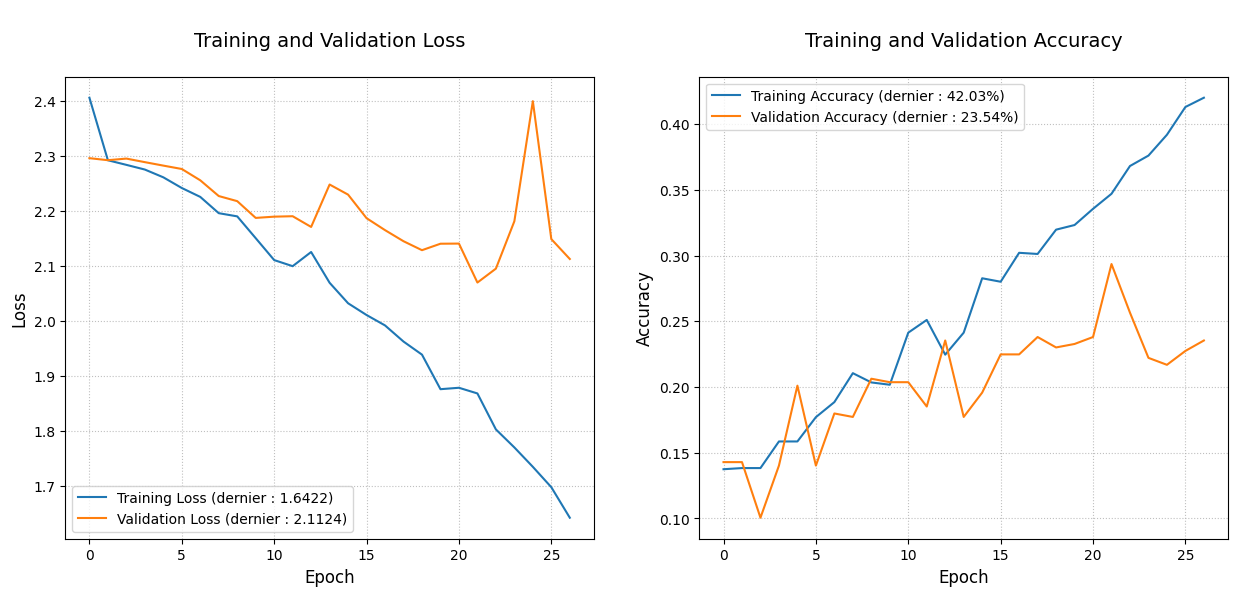

In [31]:
show_train_metrics(history=history_opti_tuning)

In [32]:
# Score du dernier epoch
print("=== Dernier epoch ===")
loss, accuracy = model_opti_tuning.evaluate(dataset_train, verbose=False)
print(f"Training Accuracy   : {accuracy:.3f}")
loss, accuracy = model_opti_tuning.evaluate(dataset_val, verbose=False)
print(f"Validation Accuracy : {accuracy:.3f}")

# Score de l'epoch optimal
print("=== Epoch optimal ===")
# Chargement des poids optimaux
model_opti_tuning.load_weights(model_opti_tuning_save_path)
loss, accuracy = model_opti_tuning.evaluate(dataset_val, verbose=False)
print(f"Validation Accuracy : {accuracy:.3f}")
loss, accuracy = model_opti_tuning.evaluate(dataset_test, verbose=False)
print(f"Test Accuracy       : {accuracy:.3f}")

=== Dernier epoch ===
Training Accuracy   : 0.544
Validation Accuracy : 0.235
=== Epoch optimal ===
Validation Accuracy : 0.294
Test Accuracy       : 0.300


=== Scores pour les prédictions ===
Accuracy score : 0.300
Precision score : 0.266
Recall score : 0.300
F1 score : 0.260


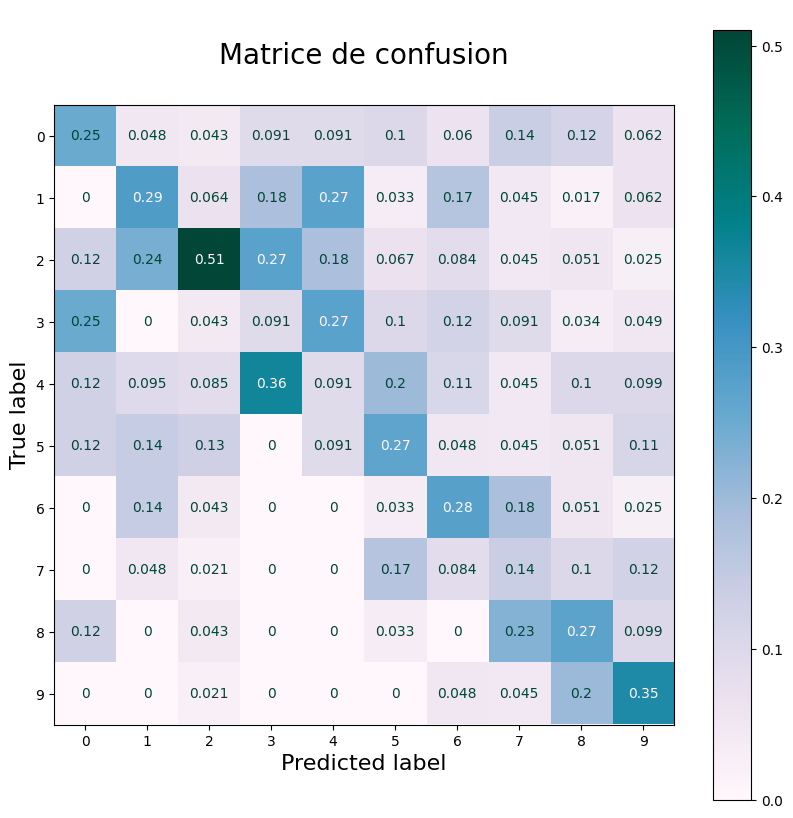

In [33]:
accuracy_opti_tuning, precision_opti_tuning, recall_opti_tuning, f1_opti_tuning = show_metrics_and_matrix(model=model_opti_tuning, dataset=dataset_test)

<div class="alert alert-info">
Le tuning des hyperparamètres a permis d'augmenter significativement les performances du modèle. L'accuracy est bien supérieure à ce que produirait une prédiction aléatoire. Ces meilleures performances sont en revanche produites au prix d'une augmentation significative de la durée d'entraînement.
</div>

### **3). Prédictions sur des nouvelles images**

Testons ce modèle sur de nouvelles images.

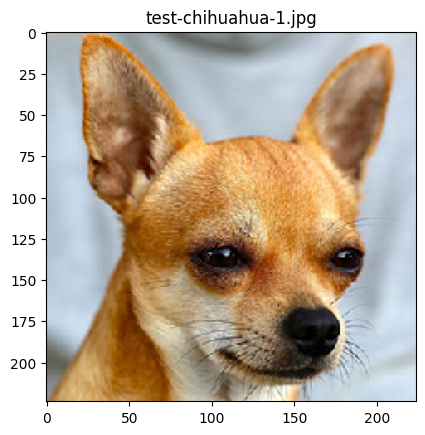

La classe prédite est : n02087394-Rhodesian_ridgeback
--------------------


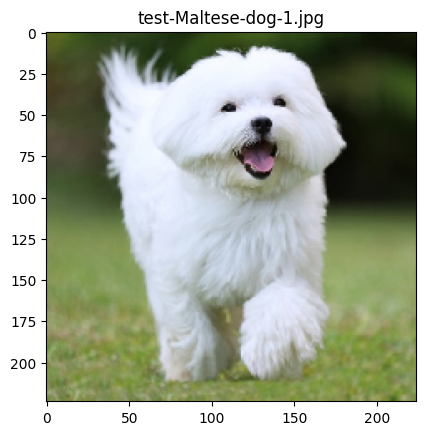

La classe prédite est : n02085936-Maltese_dog
--------------------


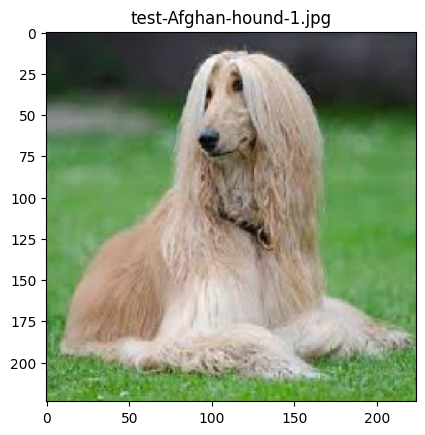

La classe prédite est : n02086910-papillon
--------------------


In [51]:
chemin = 'data/test_new/'

a_tester = [chemin + 'test-chihuahua-1.jpg',
            chemin + 'test-Maltese-dog-1.jpg',
            chemin + 'test-Afghan-hound-1.jpg',
]

for i in a_tester:
    # Chargement du fichier
    img = load_img(i, target_size=(224, 224))
    # Conversion en array
    img = img_to_array(img)
    # Rechape de l'array
    img = img.reshape(1,224,224,3)

    # Affichage de l'image
    plt.imshow(img[0].astype("uint8"))
    plt.title(i[len(chemin):])  # [len(chemin):] pour ne garder que le nom du fichier
    plt.show()

    # Prédiction sur l'image chargée
    prediction = model_opti_tuning.predict(img, verbose=False)
    prediction = np.argmax(prediction)
    # class_names : la liste des classes, déterminé précédemment
    print(f"La classe prédite est : {class_names[prediction]}")
    print("-"*20)


<div class="alert alert-info">
Le modèle en a trouvé 1 sur 3.
</div>

## **F). Conclusion**

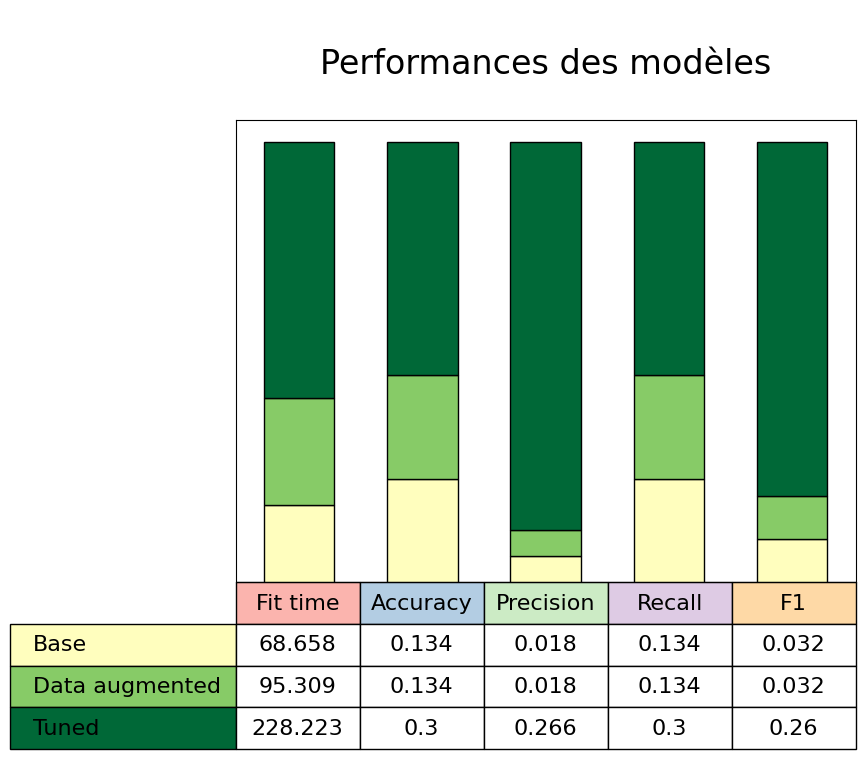

In [35]:
data = [[model_base_fit_time, accuracy_base, precision_base, recall_base, f1_base],  # model_base
        [model_opti_fit_time, accuracy_opti, precision_opti, recall_opti, f1_opti],  # model_opti
        [model_opti_tuning_fit_time, accuracy_opti_tuning, precision_opti_tuning, recall_opti_tuning, f1_opti_tuning]]  # model_opti_tuning

# Noms des colonnes et lignes
columns = ['Fit time', 'Accuracy', 'Precision', 'Recall', 'F1']
rows = ['Base', 'Data augmented', 'Tuned']

# Normalisation des données pour que la somme soit constante
# au niveau des colonnes (d'où les .T)
# Donc chaque barre cumulée aura la même taille
# Le but n'est pas de comparer les barres entre elles,
# mais les valeurs pour chaque modèles
normalized_data = np.array(data).T / np.sum(np.array(data).T, axis=1, keepdims=True)
normalized_data = normalized_data.T

# On arrondit les valeurs de data pour affichage dans le tableau
data_rounded = []
for i in range(len(data)):
    metrics = [round(metrics, 3) for metrics in data[i]]
    data_rounded.append(metrics)

# On définir les couleurs des titres de lignes
colors = plt.cm.RdYlGn_r(np.linspace(0, 0.5, len(rows)))
colors = colors[::-1]  # Inverser les couleurs
# On définir les couleurs des titres de colonnes
col_colors = plt.cm.Pastel1(np.linspace(0, 0.5, len(columns)))

# Initialiser le décalage vertical pour le graphique à barres empilées.
y_offset = np.zeros(len(columns))

fig, ax = plt.subplots(figsize=(8, 6))

# Tracé du graphique à barres empilées
for row in range(len(data)):
    ax.bar(np.arange(-1, 5, 1.4), normalized_data[row], width=0.8, linewidth=1, edgecolor='black', bottom=y_offset, color=colors[row]) # 
    y_offset = y_offset + normalized_data[row]

# On ajoute une table en dessous du graphique
the_table = ax.table(cellText=data_rounded,
                      rowLabels=rows,
                      rowColours=colors,
                      colColours=col_colors,
                      colLabels=columns,
                      loc='bottom',
                      cellLoc='center',
                      edges='closed')

# Taille du texte dans le tableau
the_table.auto_set_font_size(False)
the_table.set_fontsize(16)
# On agrandit un peu la hauteur des lignes
the_table.scale(1, 2.5)

# On masque les graduations
plt.yticks([])
plt.xticks([])

# Titre
plt.title('\nPerformances des modèles\n', fontsize=24)

# Affichage
plt.show()


<div class="alert alert-info">
Nous avons été en mesure de développer et entraîner un modèle dont la structure est basée sur VGG16. La data augmentation n'a pas permis ici d'améliorer les performances. Le tuning des hyperparamètres a permis de significativement améliorer les performances du modèle, qui produit des résultats bien meilleurs que ne le ferait une prédiction aléatoire : le modèle a donc appris. Les meilleurs résultats ont été obtenus avec des images qui ont eu un prétraitement de base (donc sans whitening).<br><br>
Cependant, bien que nous ayons réussi à faire apprendre à notre modèle, les performances restent dans l'absolu bien trop faibles pour envisager développer une application basée sur ce dernier. Le nombre d'images pour chaque classe est trop faible pour apprendre au modèle à généraliser, d'autant plus qu'une partie de ces images étaient réservées aux sets de validation et de test. Il sera intéressant de tester des méthodes de transfert learning pour voir si nous pouvons améliorer ces résultats.
</div>

### **Suppression des fichiers temporaires**

L'exécution de ce notebook a créé des dossiers/fichiers volumineux dont nous n'aurons plus besoin après. Nous allons les supprimer.

In [36]:
do_cleaning = True

# Liste des dossiers et fichiers à supprimer
dossiers = [output_folder,
]
fichiers = [model_opti_save_path,
            model_opti_tuning_save_path,
            model_base_save_path,
]

# Suppression si do_cleaning = True
if do_cleaning:
    for i in dossiers:
        shutil.rmtree(i)
    for i in fichiers:
        os.remove(i)

### **Mesure de la durée d'exécution du notebook**

In [37]:
temps_secondes = time.time() - t_notebook

# Conversion en minutes et secondes
minutes = int(temps_secondes // 60)
seconds = int(temps_secondes % 60)

# Formatage du résultat
formatted_time = f"{minutes:02}:{seconds:02}"

print(f"Durée d'exécution du notebook (hors imports) : {formatted_time}")

Durée d'exécution du notebook (hors imports) : 07:50
